# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.

## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/Colab Notebooks/ANN/Challenge 2
%ls

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/ANN/Challenge 2
 idk.ipynb   mars_for_students.npz  'UNet_dualattention (1).ipynb'


## ⚙️ Import Libraries

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


In [ ]:
device_name = tf.test.gpu_device_name()

if "GPU" not in device_name:
    print("GPU device not found")

print('Found GPU at: {}'.format(device_name))

print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

Found GPU at: /device:GPU:0
GPU available (YESS!!!!)


## ⏳ Load the Data

In [ ]:
# data = np.load("/kaggle/input/an2dl-challenge-2-202425/mars_for_students.npz")
data = np.load("mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


## Inspect the data

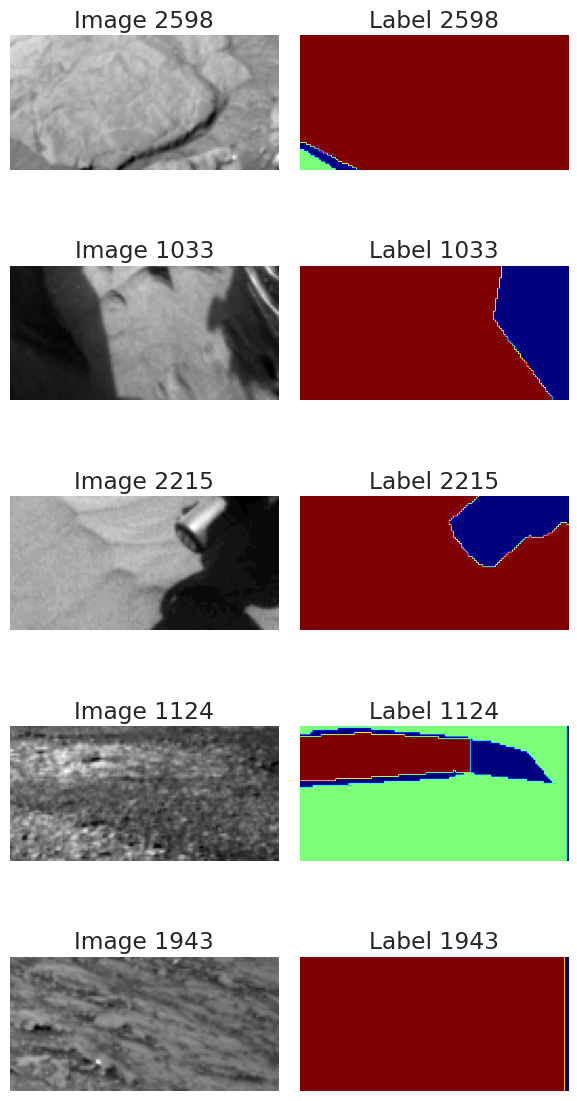

In [ ]:
# Function to plot random images and corresponding labels in a column
def plot_random_samples(X, y, num_samples=5):
    indices = np.random.choice(len(X), size=num_samples, replace=False)  # Select random indices
    plt.figure(figsize=(6, 12))  # Adjust the figure size for better visibility

    for i, idx in enumerate(indices):
        # Plot the random image
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(X[idx], cmap="gray")
        plt.title(f"Image {idx}")
        plt.axis("off")

        # Plot the corresponding label
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(y[idx], cmap="jet")
        plt.title(f"Label {idx}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize 5 random samples from the dataset
plot_random_samples(X_train, y_train, num_samples=5)

## Remove outliers

In [ ]:
print(f"Original dataset size: {X_train.shape[0]}")

# Reference mask: Mask of image 1324
reference_mask = y_train[1324]

# Find indices where masks are different from the reference mask
indices_to_keep = [i for i in range(len(y_train)) if not np.array_equal(y_train[i], reference_mask)]

# Filter the dataset to eliminate matching masks
X_train = X_train[indices_to_keep]
y_train = y_train[indices_to_keep]

# Print results
print(f"Filtered dataset size: {X_train.shape[0]}")

Original dataset size: 2615
Filtered dataset size: 2505


In [ ]:
from collections import Counter

def plot_class_distribution(y):
    # Flatten all labels to calculate pixel frequency
    flattened_labels = y.flatten()

    # Count the frequency of each class (pixel value)
    pixel_counts = Counter(flattened_labels)

    # Class names
    class_names = {
        0: "Background",
        1: "Soil",
        2: "Bedrock",
        3: "Sand",
        4: "Big Rock"
    }

    # Sort the classes for consistent plotting
    sorted_classes = sorted(pixel_counts.keys())
    print(sorted_classes)
    frequencies = [pixel_counts[cls] for cls in sorted_classes]
    class_labels = [class_names[cls] for cls in sorted_classes]

    # Plot the frequency distribution
    plt.figure(figsize=(8, 6))
    plt.bar(class_labels, frequencies, tick_label=class_labels)
    plt.title("Frequency of Pixel Classes in Labels")
    plt.xlabel("Pixel Class")
    plt.ylabel("Frequency")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

We noticed that there are no duplicates in the training set after removing the outliers. The code to perform this check has been removed to not waste computational resources.

Print images that have a specific label in order to analyze better "big rock"

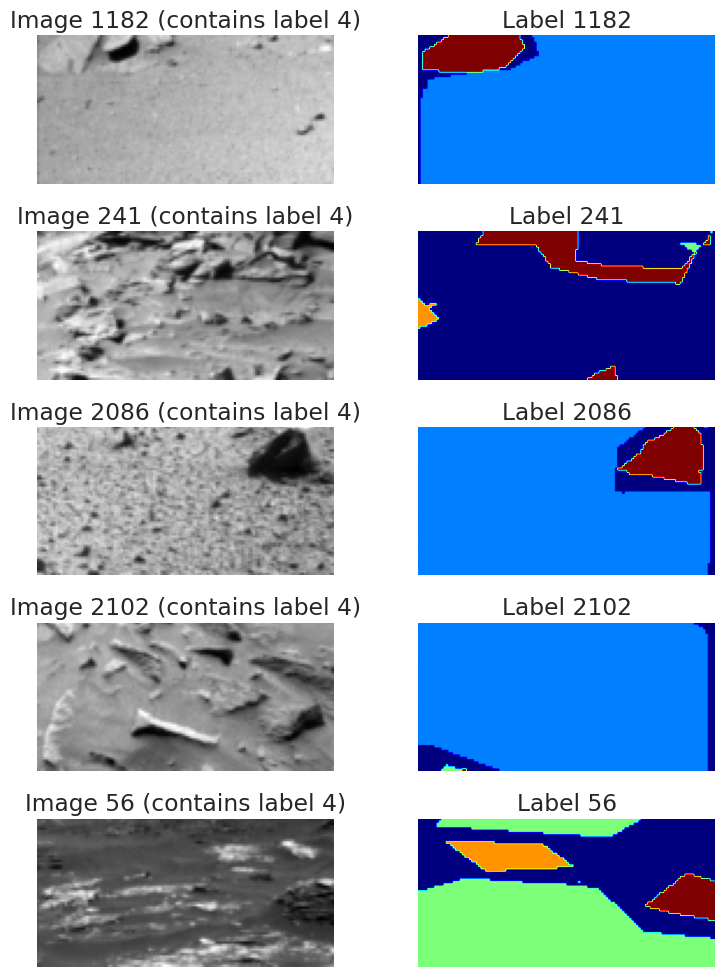

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot random images and corresponding labels containing a specific label
def plot_images_with_specific_label(X, y, label, num_samples=5):
    # Find indices where the label is present in the segmentation mask
    indices_with_label = [i for i in range(len(y)) if label in y[i]]

    # If fewer than num_samples are available, adjust the number
    num_samples = min(num_samples, len(indices_with_label))

    # Select random indices from those that contain the label
    random_indices = np.random.choice(indices_with_label, size=num_samples, replace=False)

    # Plot the selected images and corresponding labels
    plt.figure(figsize=(8, 2 * num_samples))  # Adjust figure size for better visibility
    for i, idx in enumerate(random_indices):
        # Plot the image
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(X[idx], cmap="gray")
        plt.title(f"Image {idx} (contains label {label})")
        plt.axis("off")

        # Plot the corresponding label
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(y[idx], cmap="jet")
        plt.title(f"Label {idx}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_images_with_specific_label(X_train, y_train, label=4, num_samples=5)

## Add more big rocks & split

### Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=200, random_state=12345
)

### get all necessary masks

In [ ]:
# Function to plot random images and corresponding masks in a column
def plot_samples(X, y, indices):
    """
    Plot random images and their corresponding masks.

    Parameters:
        X: numpy array of images.
        y: numpy array of masks corresponding to X.
        num_samples: Number of samples to plot.
        indices: Optional - list of specific indices to plot.
    """
    if indices is None:  # Randomly select indices if not provided
        indices = np.random.choice(len(X), num_samples, replace=False)

    num_samples = len(indices)  # Number of samples to display
    plt.figure(figsize=(8, 4 * num_samples))  # Dynamically adjust figure size

    for i, idx in enumerate(indices):
        # Plot the image
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(X[idx], cmap="gray")
        plt.title(f"Image {idx}")
        plt.axis("off")

        # Plot the corresponding mask
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(y[idx], cmap="jet")
        plt.title(f"Mask {idx}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Visualize 5 random samples from the dataset
# plot_samples(X_train, y_train, indices=indices)

In [ ]:
indices = [] # indices of images that contain the big rock class
for idx in range(len(y_train)):
  img = y_train[idx]
  if 4 in np.unique(img):
      _, count = np.unique(img, return_counts=True)
      indices.append(idx)

In [ ]:
from scipy.ndimage import label

def extract_regions_with_value_4(img):
    """
    Extract all regions containing the value 4 in the input array and return individual numpy arrays
    where each region is represented, with the rest set to 0.

    Args:
        img (numpy.ndarray): A 2D array with pixel values (0-4).

    Returns:
        List[numpy.ndarray]: A list of numpy arrays, each containing a single region with 4s.
    """
    binary_mask = img == 4  # Create a binary mask where pixel value is 4
    labeled_array, num_features = label(binary_mask)  # Label connected regions where the mask is True

    region_arrays = []
    for region_id in range(1, num_features + 1):
        region_mask = labeled_array == region_id  # Mask for the current region
        region_array = np.zeros_like(img)  # Initialize a new array with zeros
        region_array[region_mask] = 4  # Set the pixels of the current region to 4
        region_arrays.append(region_array)

    return region_arrays


rock_labels = []
rock_images = []
rock_inv_masks = []

for i in indices:
    img = y_train[i]
    regions = extract_regions_with_value_4(img)  # Get regions for the current index

    for r in regions:
      rock_labels.append(r)  # Extend the list with the regions (each region is a numpy array)

    regions = [region / 4 for region in regions]

    for r in regions:
      rock_images.append(X_train[i] * r)

    for r in regions:
      r -= 1
      rock_inv_masks.append(-r)

to_print = []
for i in range(len(rock_labels)):
  to_print.append(i)

# plot_samples(rock_images, rock_labels, to_print)

### add the rocks

In [ ]:
def add_rocks_to_random_images(X, y, num_of_rocks=5, freq=0.4):
  indices = np.random.choice(len(X), size=int(freq * len(X)), replace=False)  # Select random indices
  resulting_images = []
  resulting_labels = []

  images = X[indices]
  labels = y[indices]

  for idx in range(len(images)):
    r_idxs = np.random.choice(len(rock_labels), size=num_of_rocks, replace=False)
    img = images[idx]
    label = labels[idx]

    for r_idx in r_idxs:
      img = img * rock_inv_masks[r_idx] # makes room for the rock in the image
      label = label * rock_inv_masks[r_idx] # makes room for the rock in the label

      img = img + rock_images[r_idx] # pastes the rock to the image
      label = label + rock_labels[r_idx] # pastes the mask to the label

    resulting_images.append(img)
    resulting_labels.append(label)

  plot_samples(resulting_images, resulting_labels, [0,1,2,3,4,5,6,7,8,9])

  return np.concatenate((X, resulting_images)), np.concatenate((y, resulting_labels))

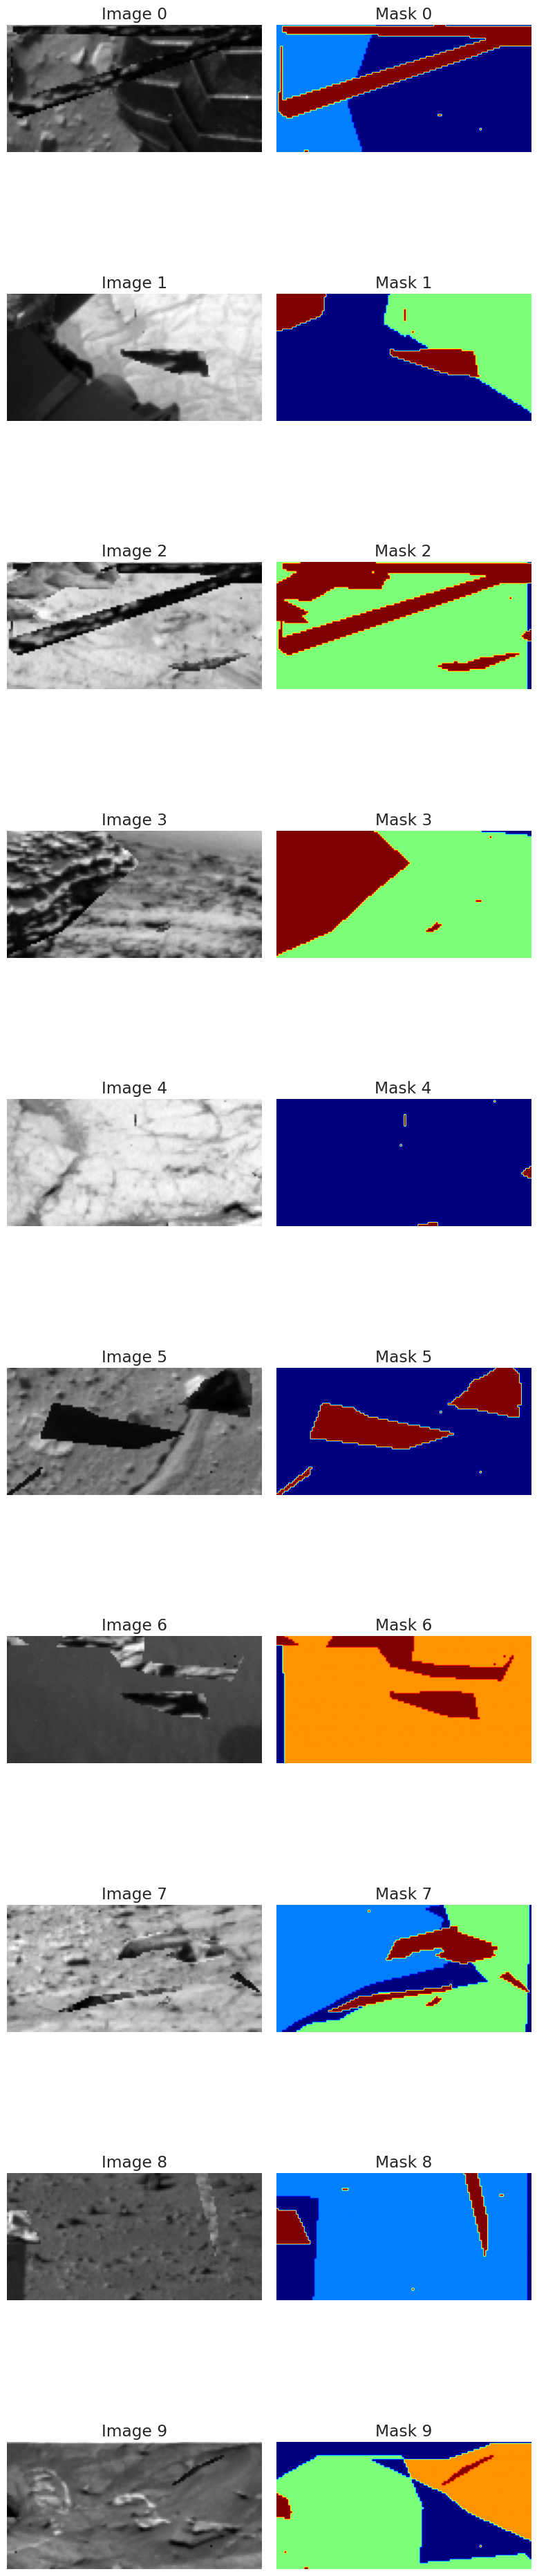

In [ ]:
X_train, y_train = add_rocks_to_random_images(X_train, y_train, num_of_rocks=5, freq=0.4)

### Check distribution

[0.0, 1.0, 2.0, 3.0, 4.0]


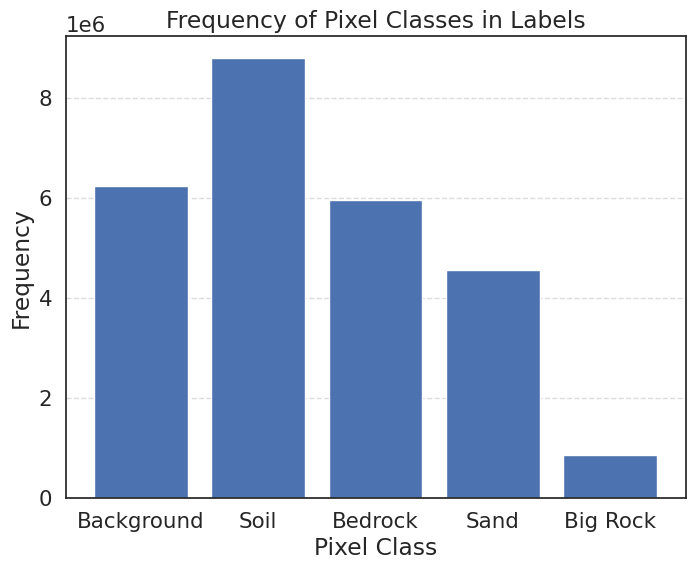

In [ ]:
plot_class_distribution(y_train)

## Augmentation

In [ ]:
import cv2

def random_shift_image(image, label,max_shift_x, max_shift_y):
    """Shifts an image by a random amount of pixels both vertically and horizontally.

    Args:
        image: The input image as a NumPy array.
        max_shift_x: Maximum horizontal shift in pixels (positive or negative).
        max_shift_y: Maximum vertical shift in pixels (positive or negative).

    Returns:
        The shifted image as a NumPy array.
    """

    # Generate random shift values
    shift_x = np.random.randint(-max_shift_x, max_shift_x + 1)
    shift_y = np.random.randint(-max_shift_y, max_shift_y + 1)

    # Create translation matrix
    translation_matrix = np.float32([[1, 0, shift_x], [0, 1, shift_y]])

    # Get image dimensions
    height, width = image.shape[:2]

    # Apply affine transformation
    shifted_image = cv2.warpAffine(image, translation_matrix, (width, height))
    shifted_label = cv2.warpAffine(label, translation_matrix, (width, height))

    return shifted_image, shifted_label

In [ ]:
# Function to augment images containing specific label
def augment_images_with_label(X, y, label):
    augmented_X, augmented_y = [], []

    # Find indices of images containing the specific label
    indices_with_label = [i for i in range(len(y)) if label in y[i]]

    for i in indices_with_label:
        img, lbl = random_shift_image(X[i], y[i], max_shift_x=64, max_shift_y=32)
        augmented_X.append(img)
        augmented_y.append(lbl)

        if len(augmented_X) < 10:
            plot_samples(augmented_X, augmented_y, [len(augmented_X) - 1])
            plot_samples(X, y, [i])

    # Convert lists to numpy arrays
    augmented_X = np.array(augmented_X)
    augmented_y = np.array(augmented_y)

    # Combine original and augmented datasets
    X_combined = np.concatenate((X, augmented_X), axis=0)
    y_combined = np.concatenate((y, augmented_y), axis=0)

    return X_combined, y_combined

Original dataset size: 3227


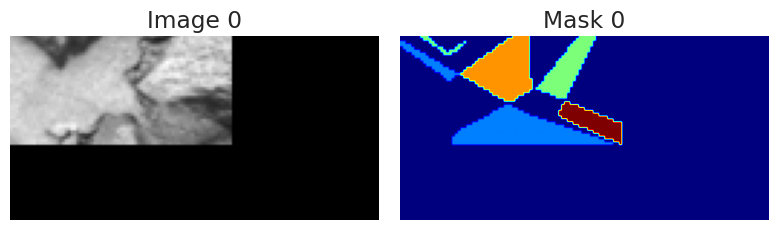

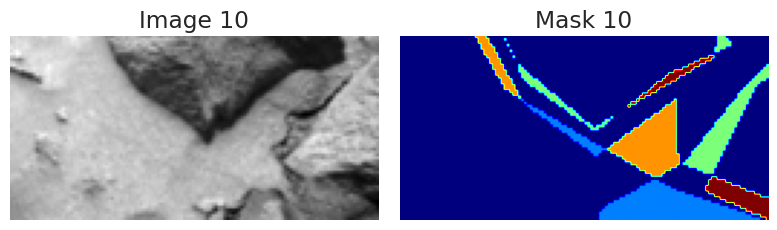

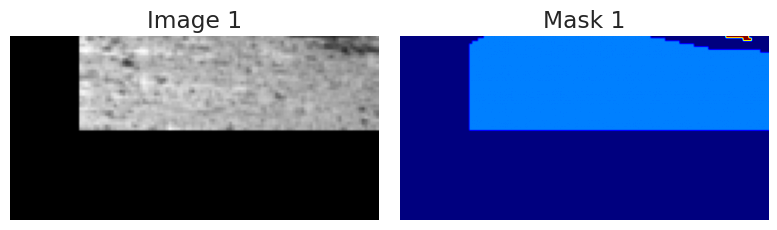

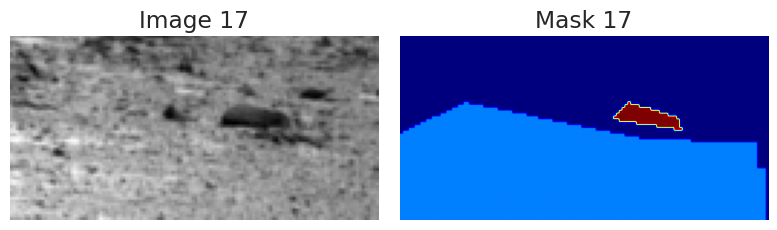

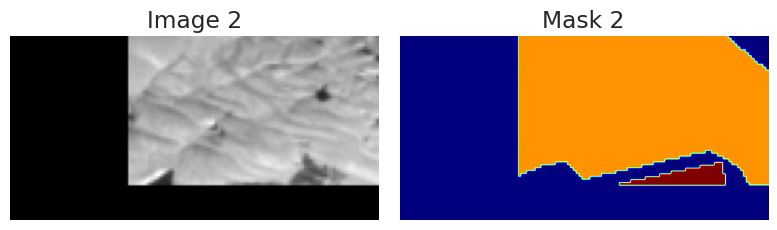

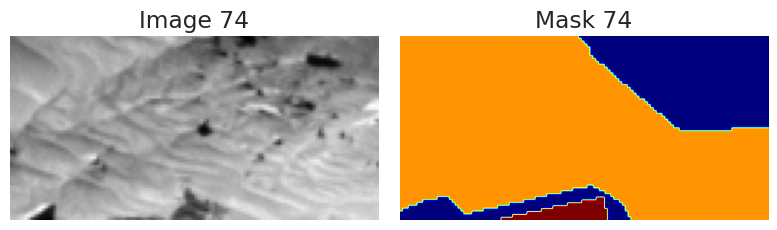

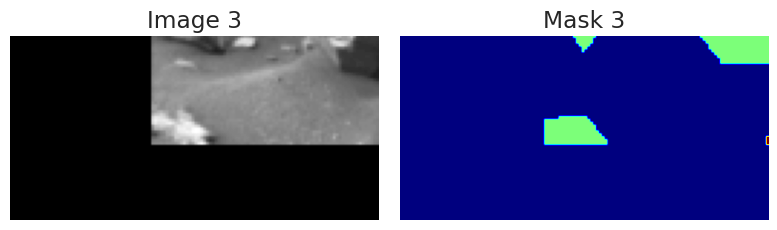

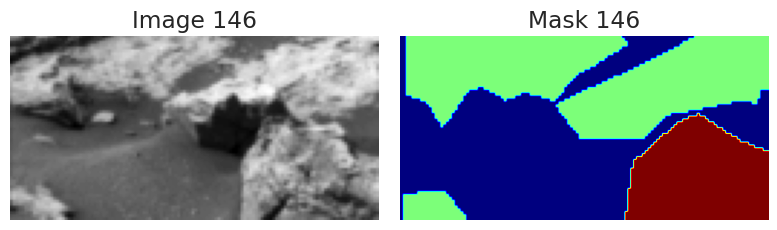

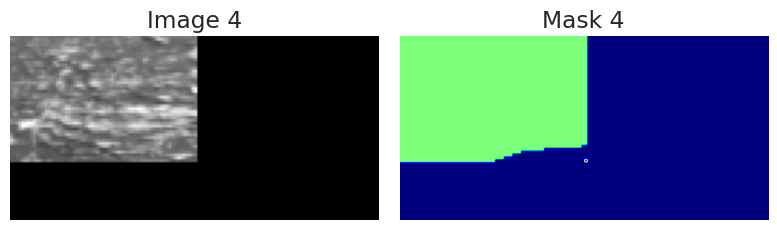

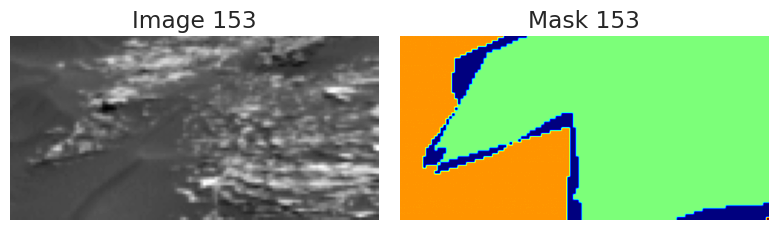

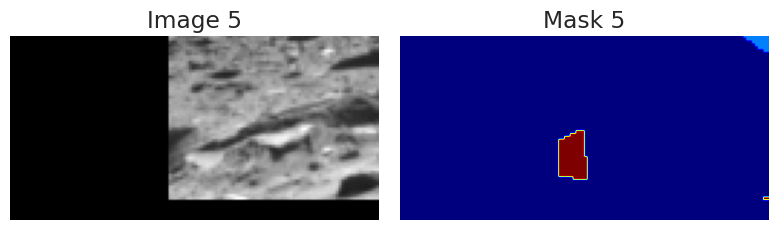

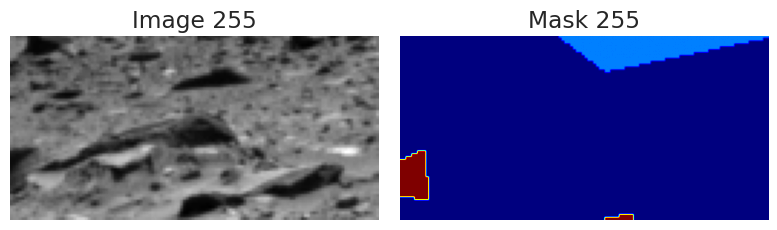

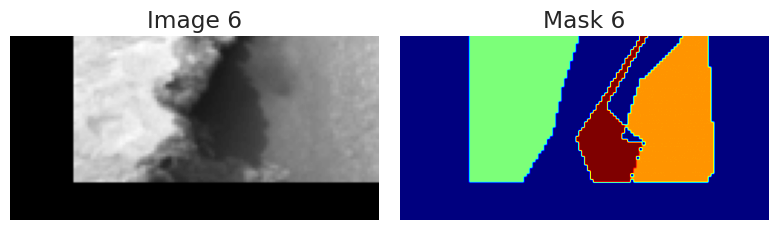

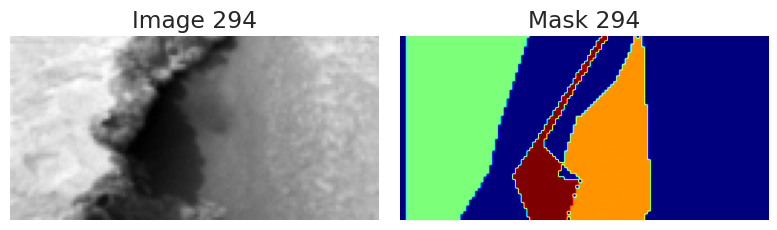

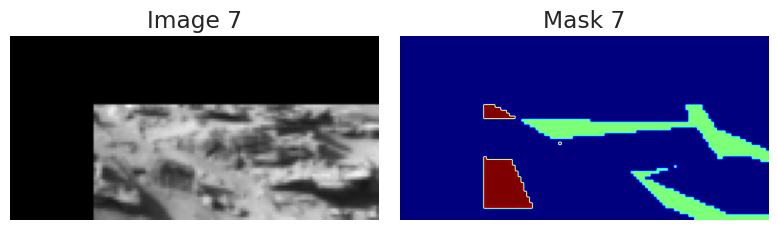

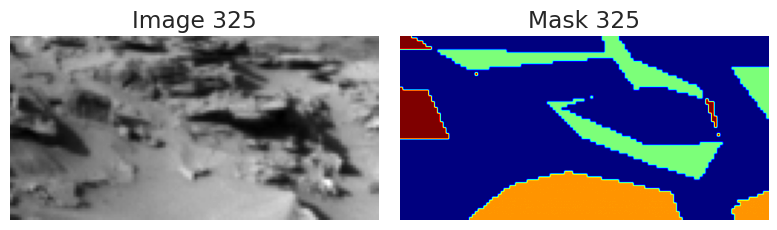

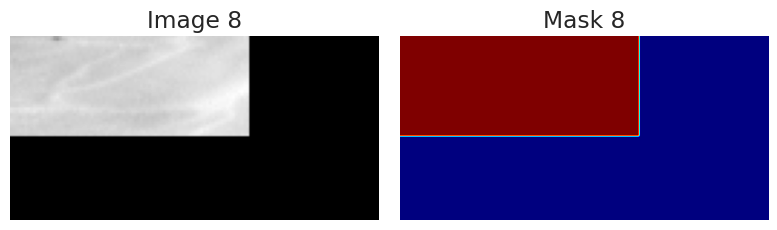

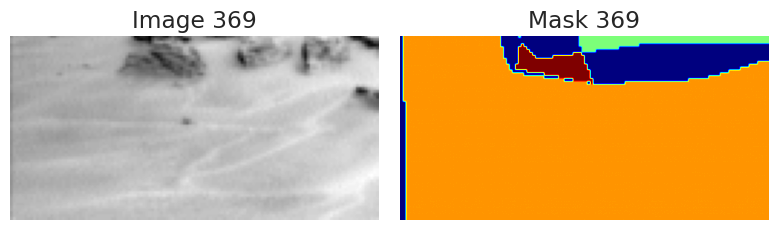

Augmented dataset size: 4209


In [ ]:
print(f"Original dataset size: {X_train.shape[0]}")

# Apply the augmentation function
X_train, y_train = augment_images_with_label(X_train, y_train, label=4)

# Verify the results
print(f"Augmented dataset size: {X_train.shape[0]}")

[0.0, 1.0, 2.0, 3.0, 4.0]


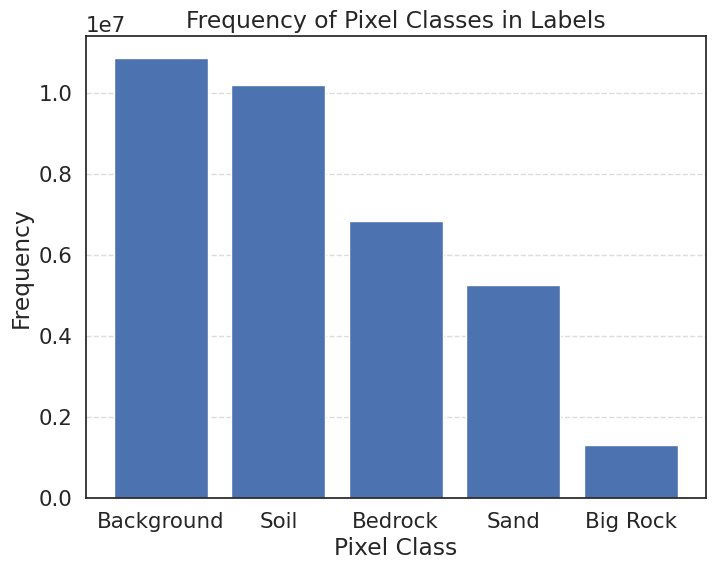

In [ ]:
plot_class_distribution(y_train)

## Inspect the data

In [ ]:
# Function to plot random images and corresponding labels in a column
def plot_specific_sample(X, y, index):
    plt.figure(figsize=(6, 12))  # Adjust the figure size for better visibility

        # Plot the random image
    plt.subplot(1, 2, 1)
    plt.imshow(X[index], cmap="gray")
    plt.title(f"Image {index}")
    plt.axis("off")

    # Plot the corresponding label
    plt.subplot(1, 2, 2)
    plt.imshow(y[index], cmap="jet")
    plt.title(f"Label {index}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
# for i in range(50):
#     plot_specific_sample(X_train, y_train, 2430 + i)

## 🛠️ Train and Save the Model

In [ ]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0
X_val = X_val[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [ ]:
import tensorflow as tf
from tensorflow import keras as tfk
import tensorflow as tf
from tensorflow.keras import layers

class ChannelPooling(tfkl.Layer):
    def __init__(self, axis=-1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.axis = axis
        self.concat = layers.Concatenate(axis=self.axis)

    def call(self, inputs):
        average_pooling = tf.expand_dims(tf.reduce_mean(inputs, axis=-1), axis=-1)
        max_pooling = tf.expand_dims(tf.reduce_max(inputs, axis=-1), axis=-1)
        return self.concat([average_pooling, max_pooling])

    def get_config(self):
        config = super().get_config()
        config.update({"axis": self.axis})
        print(type(config))
        return dict(config)


def spatial_attention_block(input_tensor):
    compressed_feature_map = ChannelPooling(axis=-1)(input_tensor)
    feature_map = layers.Conv2D(1, kernel_size=(1, 1))(compressed_feature_map)
    feature_map = tfk.activations.sigmoid(feature_map)
    return input_tensor * feature_map


def channel_attention_block(input_tensor):
    channels = list(input_tensor.shape)[-1]
    average_pooling = layers.GlobalAveragePooling2D()(input_tensor)
    feature_descriptor = layers.Reshape((1, 1, channels))(average_pooling)
    feature_activations = layers.Conv2D(
        filters=channels // 8, kernel_size=(1, 1), activation="relu"
    )(feature_descriptor)
    feature_activations = layers.Conv2D(
        filters=channels, kernel_size=(1, 1), activation="sigmoid"
    )(feature_activations)
    return input_tensor * feature_activations


def dual_attention_unit_block(input_tensor):
    channels = list(input_tensor.shape)[-1]
    feature_map = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(input_tensor)
    feature_map = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(
        feature_map
    )
    channel_attention = channel_attention_block(feature_map)
    spatial_attention = spatial_attention_block(feature_map)
    concatenation = layers.Concatenate(axis=-1)([channel_attention, spatial_attention])
    concatenation = layers.Conv2D(channels, kernel_size=(1, 1))(concatenation)
    return layers.Add()([input_tensor, concatenation])

In [ ]:
from tensorflow.keras import layers

# Definizione del Transformer Block basilare
class TransformerBlock(tfkl.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs): # Add **kwargs here
        super(TransformerBlock, self).__init__(**kwargs) # Pass **kwargs to super().__init__
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        # Multi-Head Attention
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        # Feed-Forward Network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class PatchAndTransformerLayer(Layer):
    def __init__(self, patch_size, embedding_dim, num_heads, intermediate_dim, enc=True, name='transformer', **kwargs):
        super(PatchAndTransformerLayer, self).__init__(name=name , **kwargs)
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.intermediate_dim = intermediate_dim
        self.name = name

        # Proiezione delle patch
        self.projection = tf.keras.layers.Dense(embedding_dim, name=f"{name}_projection")

        if enc:
            # Transformer Encoder
            self.transformer_encoder = TransformerEncoder(
                num_heads=num_heads,
                intermediate_dim=intermediate_dim,
                name=f"{name}_transformer_encoder"
            )
        else :
            self.transformer_encoder = TransformerDecoder(
                num_heads=num_heads,
                intermediate_dim=intermediate_dim,
                name=f"{name}_transformer_decoder"
            )

        # Upsampling per ripristinare la dimensione
        self.upsample = tf.keras.layers.UpSampling2D(
            size=(patch_size, patch_size),
            interpolation='bilinear',
            name=f"{name}_upsample"
        )

    def call(self, inputs):
        # Estrai le patch
        patches = tf.image.extract_patches(
            images=inputs,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )  # Shape: (batch_size, num_patches_h, num_patches_w, patch_size*patch_size*C)

        batch_size = tf.shape(inputs)[0]
        num_patches = tf.shape(patches)[1] * tf.shape(patches)[2]
        patch_dim = self.patch_size * self.patch_size * tf.shape(inputs)[-1]

        # Appiattisci le patch
        x = tf.reshape(patches, [batch_size, num_patches, patch_dim])

        # Proietta le patch a embedding_dim
        x = self.projection(x)

        # Passa attraverso il Transformer Encoder
        x = self.transformer_encoder(x)

        # Ripristina le dimensioni spaziali
        new_height = tf.shape(inputs)[1] // self.patch_size
        new_width = tf.shape(inputs)[2] // self.patch_size
        x = tf.reshape(x, [batch_size, new_height, new_width, self.embedding_dim])

        # Upsample per ripristinare la dimensione originale
        x = self.upsample(x)

        return x

    def get_config(self):
        config = super(PatchAndTransformerLayer, self).get_config()
        config.update({
            "patch_size": self.patch_size,
            "embedding_dim": self.embedding_dim,
            "num_heads": self.num_heads,
            "intermediate_dim": self.intermediate_dim,
            "name": self.name
        })
        return config


In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''): # unet blcoks are basically just conv layers...
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    use_bias=False,
):
    x = tfk.layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=tfk.initializers.HeNormal(),
    )(block_input)
    x = tfk.layers.BatchNormalization()(x)
    return tfk.ops.leaky_relu(x)

def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x =tfk.layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool =tfk.layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x =tfk.layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def build_unet(depth, input_layer, net_idx, use_transformer=False):
    db = []  # Downsampling blocks storage
    block = input_layer

    # Downsampling Path
    for i in range(depth):
        block = unet_block(block, 32 * (1 << i), name=f'down_block_{net_idx}.{i}_')
        db.append(block)
        block = tfkl.MaxPooling2D()(block)

    # Create an instance of PatchAndTransformerLayer
    transformer_encoder = TransformerBlock(
        embed_dim=256,
        num_heads=3,
        ff_dim=512
    )
    block = transformer_encoder(block)

    # Bottleneck with optional Transformer
    block = unet_block(block, 32 * (1 << depth), name=f'bottleneck_{net_idx}')

    transformer_decodedr = TransformerBlock(
        embed_dim=512,
        num_heads=3,
        ff_dim=256
    )
    block = transformer_decodedr(block)

    block = dual_attention_unit_block(block)

    # Dilated Spatial Pyramid Pooling
    block = DilatedSpatialPyramidPooling(block)

    # Upsampling Path
    for i in range(depth):
        block = tfkl.UpSampling2D()(block)
        block = tfkl.Concatenate()([block, db[depth - i - 1]])
        block = unet_block(block, 32 * (1 << (depth - i - 1)), name=f'up_block_{net_idx}.{i}_')

    return block

In [ ]:
input_layer = tfkl.Input(shape=(64, 128, 1), name='input_layer')

# First UNet with transformer in the bottleneck
last_block = build_unet(depth=4, input_layer=input_layer, net_idx=1, use_transformer=True)

# Second UNet (no transformer, for comparison)
last_block = build_unet(depth=4, input_layer=last_block, net_idx=2, use_transformer=False)

# Final output layer
output_layer = tfkl.Conv2D(5, kernel_size=1, padding='same', activation="softmax", name='output_layer')(last_block)

# Build the model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet_with_Transformer')

# Print model summary
model.summary(expand_nested=True, show_trainable=True)

Model: "UNet_with_Transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_1.0_conv1   │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_1.0_bn1     │ (None, 64, 128, 32)  │          128 │ down_block_1.0_con… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_1.0_activa… │ (None, 64, 128, 32)  │            0 │ down_block_1.0_bn1… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_1.0_conv2   │ (None, 64, 128, 32)  │        9,248 │ down_block_1.0_act… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_1.0_bn2     │ (None, 64, 128, 32)  │          128 │ down_block_1.0_con… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_1.0_activa… │ (None, 64, 128, 32)  │            0 │ down_block_1.0_bn2… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_32       │ (None, 32, 64, 32)   │            0 │ down_block_1.0_act… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_1.1_conv1   │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d_32[0… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_1.1_bn1     │ (None, 32, 64, 64)   │          256 │ down_block_1.1_con… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_1.1_activa… │ (None, 32, 64, 64)   │            0 │ down_block_1.1_bn1… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_1.1_conv2   │ (None, 32, 64, 64)   │       36,928 │ down_block_1.1_act… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_1.1_bn2     │ (None, 32, 64, 64)   │          256 │ down_block_1.1_con… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 42,373,963 (161.64 MB)

 Trainable params: 42,356,043 (161.58 MB)

 Non-trainable params: 17,920 (70.00 KB)

In [ ]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [ ]:
# Model saving
class Checkpoint(tf.keras.callbacks.Callback):
    def __init__(self, frequency=10, filepath='UNet_epoch_{epoch:02d}.keras'):
        super().__init__()
        self.frequency = frequency
        self.filepath = filepath

    def on_epoch_end(self, epoch, logs=None):
      if epoch % self.frequency == 0:  # Checkpoint every "frequency" epochs
        if epoch >= 20:
            self.model.save(self.filepath.format(epoch=epoch))
            print(f" Model saved at epoch {epoch} to {self.filepath.format(epoch=epoch)}")
        if epoch != 0:
          self.check_predictions()

    def check_predictions(self):
        preds = self.model.predict(X_test)
        preds = np.argmax(preds, axis=-1)
        labels, counts = np.unique(preds, return_counts=True)
        for i in range(len(counts)):
            print(f'label {labels[i]} has {counts[i]} samples')

In [ ]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=tfk.losses.SparseCategoricalCrossentropy(ignore_class=0),
    optimizer=tf.keras.optimizers.AdamW(1e-3),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [ ]:
# Train the model
history = mo<del.fit(
    x=X_train,
    y=y_train,
    epochs=1000,
    validation_data=(X_val, y_val),
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        Checkpoint(frequency=10),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=15, min_delta=1e-5)
    ],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.3131 - loss: 1.2572 - mean_iou: 0.2068 - val_accuracy: 0.2073 - val_loss: 2.6749 - val_mean_iou: 0.0688 - learning_rate: 0.0010
Epoch 2/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 98s 391ms/step - accuracy: 0.3996 - loss: 0.9335 - mean_iou: 0.3577 - val_accuracy: 0.1965 - val_loss: 5.5093 - val_mean_iou: 0.0938 - learning_rate: 0.0010
Epoch 3/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 82s 390ms/step - accuracy: 0.4576 - loss: 0.8133 - mean_iou: 0.4124 - val_accuracy: 0.2243 - val_loss: 3.0628 - val_mean_iou: 0.0829 - learning_rate: 0.0010
Epoch 4/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 82s 389ms/step - accuracy: 0.4906 - loss: 0.7418 - mean_iou: 0.4099 - val_accuracy: 0.4863 - val_loss: 1.0243 - val_mean_iou: 0.3386 - learning_rate: 0.0010
Epoch 5/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 81s 383ms/step - accuracy: 0.5159 - loss: 0.6550 - mean_iou: 0.5637 - val_accuracy: 0.3926 - val_loss: 2.1038 - val_mean_iou: 0.2594 - learning_rate: 0.0010
Epoch 6

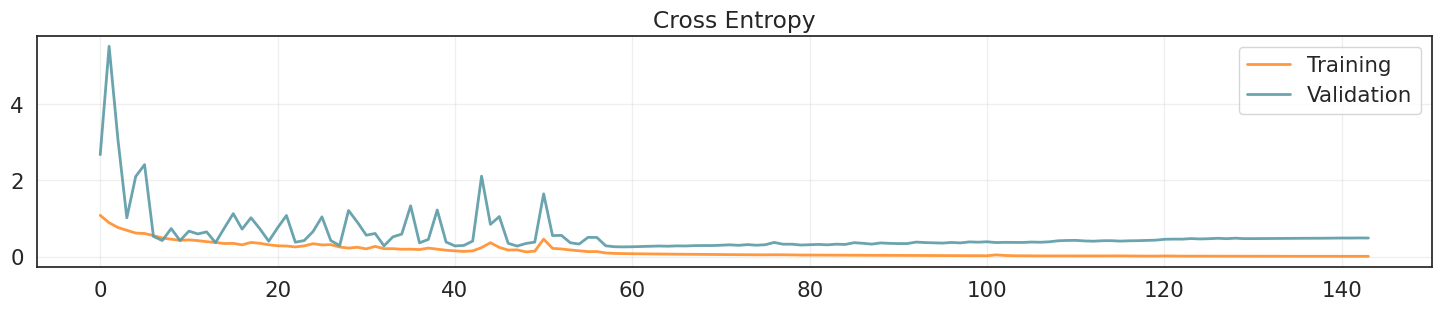

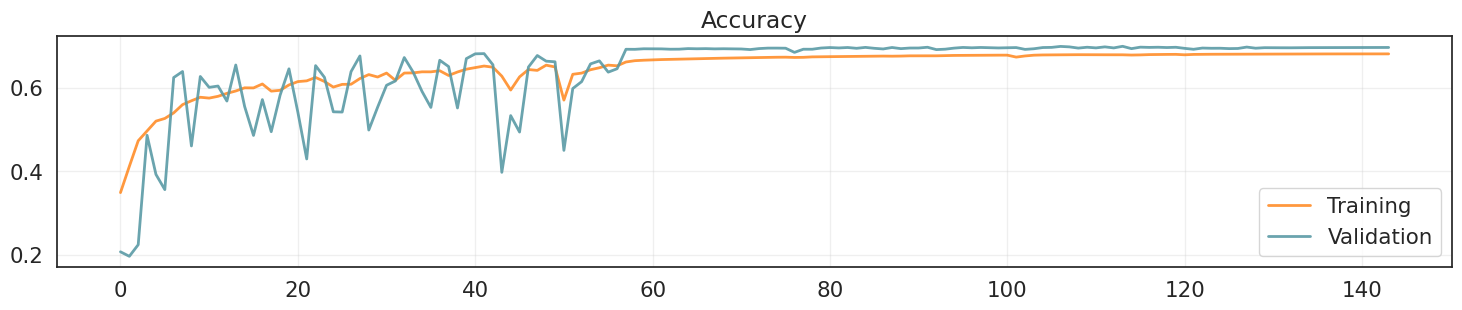

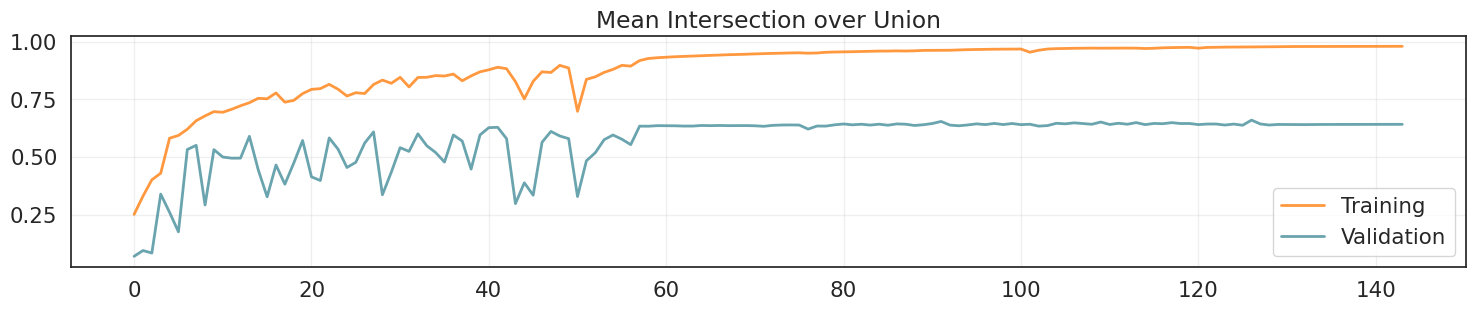

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.



In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
model = tf.keras.models.load_model(
    model_filename,
    compile=False,
    custom_objects={ 'ChannelPooling':ChannelPooling, 'TransformerBlock': TransformerBlock}
)


# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(1e-3),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])]
)

In [ ]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 34s 95ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:

timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```